In [1]:
import igl
import math
import scipy as sp
import numpy as np
import meshplot as mp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial as sp_spatial
import numba
import os
root_folder = os.getcwd()

In [2]:
v_init, f = igl.read_triangle_mesh(os.path.join(root_folder, "simulated_annealing.off"))
#v1, f1 = igl.read_triangle_mesh(os.path.join(root_folder, "Oblate_Finer.off"))
### Parameters for running computation
global Kb
global Kv
global Ka
global gamma
global KbT
global delT
global Kal
Kal=1
Ka=2
Kv=10
Kb=0.01
H0=0
Volume_t= 0.92* 3.14 * 4 / 3
Area_t=4*3.14
KbT=0.00001
charTimeStep=0.02
isAdaptiveStep=False
#hdt=0.5*dt
iterations = 500000
logfrequency = 100
figfrequency = 1000
tolerance = 1e-6
maxError = 3000

#v_init,f=igl.upsample(v1,f1,1)
gamma=1#*(len(v1)/len(v_init))

#max(v1[:,2])
rp=0.15  ###radius of nanoparticle
####center of radious 
rho=0.1*rp ### Potential Range Distance
u=2.0
U=(Kb*u)/((rp)**2)
x=np.amax(v_init[:,0])+rp+1*rho
print(x)
y=0
z=0
###rp diameter of particle

##output initial configuration
filename='dynamics_init.png'
fig = plt.figure(figsize =(14, 8))
ax = plt.axes(projection ='3d')
surf=ax.plot_trisurf(v_init[:,0], v_init[:,1], v_init[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.3, alpha=0.0, shade=False)
u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x1 = (rp*(np.cos(u) * np.sin(v1)))+x
y1 = (rp*(np.sin(u) * np.sin(v1)))
z1 = (rp*(np.cos(v1)))
surf=ax.plot_surface(x1, y1, z1)
ax.view_init(90,180)
ax = plt.gca()
ax.set_xlim([-1, 1.5])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_proj_type('ortho')
ax.set_box_aspect((xmax-xmin, ymax-ymin,ymax-ymin))
ax.set_zticks([])
plt.savefig(os.path.join(root_folder,'out/',filename))
plt.close()

1.1435322369682759


import meshzoo
import optimesh
points,cells = meshzoo.icosa_sphere(12)

class Sphere:
    def f(self, x):
        return 1.0 - (x[0] ** 2 + x[1] ** 2 + x[2] ** 2)

    def grad(self, x):
        return -2 * x
v_init, f= optimesh.optimize_points_cells(
    points,cells,"CVT (full)",1.0e-2,100,verbose=False,implicit_surface=Sphere(),
    # step_filename_format="out{:03d}.vtk"
)
rc=igl.avg_edge_length(v_init,f)*1.72
mp.jupyter()
p=mp.plot(v_init,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
                               "width": 300, "height": 300},return_plot=True)
        #p.add_lines(v,v+1*FB, shading={"line_color": "red"})
print(len(v_init))
print(rc)
max(v_init[:,0])

In [3]:
###Energy Calculations /// Area+Bending+Volume
# @numba.jit
def Energy_area(v,f,Area_t):
    Area_new=cal_areatot(v,f)
    Energy_Area=Ka*((Area_new-Area_t)**2)/Area_t
    return Energy_Area
# @numba.jit
def Energy_volume(v,f,Volume_t):
    volume_new=cal_volumetot(v,f)
    Energy_volume=Kv*((volume_new-Volume_t)**2)/Volume_t
    return Energy_volume  

In [4]:
def adjacent_face(v,f):
    df=pd.DataFrame(f,columns=list('ABC'))
    row_numbers=[]
    for i in range(len(v)):
        row_numbers.append((df.index[(df['A'] == i)|(df['B'] == i) | (df['C'] == i)].tolist()))
    return row_numbers
def cal_areatot(v,f):
    dbl_area = igl.doublearea(v, f)    
    Areatot = np.sum(dbl_area)/2
    return Areatot
@numba.jit
def cal_volumetot(v,f):
    Volumetot = 0
    for i in range(len(f)):
        sum=0
        p0x=v[f[i][0]][0]
        p0y=v[f[i][0]][1]
        p0z=v[f[i][0]][2]
        p1x=v[f[i][1]][0]
        p1y=v[f[i][1]][1]
        p1z=v[f[i][1]][2]
        p2x=v[f[i][2]][0]
        p2y=v[f[i][2]][1]
        p2z=v[f[i][2]][2]
        v321= p2x*p1y*p0z
        v231= p1x*p2y*p0z
        v312= p2x*p0y*p1z
        v132= p0x*p2y*p1z
        v213= p1x*p0y*p2z
        v123= p0x*p1y*p2z
        sum=(-v321+ v231+ v312-v132-v213+ v123) / 6.0
        #print(sum)
        Volumetot+=sum
    return Volumetot

def areaGrad(v,f):
    #n=igl.per_vertex_normals(v,f) ## not using per_vertex_normals for areaGrad direction
    l = igl.cotmatrix(v, f) ###laplacian-operator
    ag = -l.dot(v)
    return ag
def volGrad(v,f):
    npv = igl.per_vertex_normals(v, f)
    face_normal=igl.per_face_normals(v,f,npv)
    dbl_area = igl.doublearea(v, f)
    adjacent_vertices=igl.adjacency_list(f)
    adjacent_faces=adjacent_face(v,f)
    volumegrad=[]
    for i in range(len(v)):
        vol_ij=0
        for j in range(len(adjacent_faces[i])):
            k=adjacent_faces[i][j]
            Area=dbl_area[k]/2
            FaceNorm=face_normal[k]
            vol_ij += (1/3)*Area*FaceNorm
        volumegrad.append(vol_ij)
    return np.array(volumegrad)
def ver_new(v,f):
    adjacent_faces=adjacent_face(v,f)
    Area=igl.doublearea(v,f)
    n = igl.per_vertex_normals(v, f)
    face_normal=igl.per_face_normals(v,f,n)
    v_b=igl.barycenter(v,f)
    v_new=[]
    for i in range(len(v)):
        face_area=Area[adjacent_faces[i]]
        face_area_sum=np.sum(face_area)
        v_centroid=v_b[adjacent_faces[i]]
        sum_of_area_centroid=np.dot(face_area,v_centroid)
        v_avg=sum_of_area_centroid/face_area_sum
        fnorm=face_normal[adjacent_faces[i]]
        fsum=np.sum(fnorm,axis=0)
        lamda=(np.dot(v_avg,fsum)-np.dot(v[i],fsum))/np.dot(fsum,fsum)
        v_new.append(v_avg-lamda*fsum)    
    return np.array(v_new)

In [5]:
###Force  and Energy Calculations from bending

def Force_Bending(v,f):
    npv = igl.per_vertex_normals(v, f)
    K = igl.gaussian_curvature(v, f)
    l = igl.cotmatrix(v, f) ###laplacian-operator
    m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    area_voronoi=m.diagonal()
    minv = sp.sparse.diags(1 / m.diagonal())
    Hn = -minv.dot(l.dot(v))/2
    H_mean = np.linalg.norm(Hn, axis=1)
    sign_H = np.sign(np.sum(Hn*npv, axis=1))
    #if (min(sign_H)<0):
    #    print('H_mean changes sign')
    H_mean_signed = H_mean*sign_H
    Lap_H = minv.dot(l.dot(H_mean_signed-H0))
    kn = minv.dot(K)
    first_term = 2*(H_mean_signed-H0)*(H_mean_signed**2 + H0*H_mean_signed -kn)
    totalforce = first_term + Lap_H
    #for i in range (len(v)):
    Force_bending = 2*Kb*npv*totalforce[:,None]*area_voronoi[:,None]
    Eb = 2*Kb*(((H_mean_signed-H0)**2))*area_voronoi
    total_EB = np.sum(Eb)
    
    return Force_bending,total_EB

In [6]:
###Force from Area Constraints
@numba.jit
def Force_Area(Area_t,grad_Area,Area_new):
    Force_Area = -2*(Ka)*((Area_new-Area_t)/Area_t)*grad_Area
    ## Area constraint is not the same as in mem3dg
    Energy_Area = Ka*(Area_new-Area_t)**2/Area_t
    return Force_Area,Energy_Area

In [7]:
###Force from Volume Area Constraints
@numba.jit
def Force_Volume(Volume_t,grad_Volume,Volume_new):
    Force_Volume=-2*(Kv)*((Volume_new-Volume_t)/Volume_t)*grad_Volume 
    ## Volume constraint is not the same as in mem3dg
    Energy_Volume = Kv*(Volume_new-Volume_t)**2/Volume_t
    return Force_Volume,Energy_Volume

In [8]:
tol = 1e-10
def Force_Adhesive(v, f, x, y, z, rho, U, AG):
    distance = np.zeros(len(v))
    coef = np.zeros(len(v))
    dc = np.zeros(len(v))
    coefficinet_derivative_x = np.zeros(len(v))
    coefficinet_derivative_y = np.zeros(len(v))
    coefficinet_derivative_z = np.zeros(len(v))
    rc = 5.0*rho

    for i in range(len(v)):
        distance[i] = (np.sqrt((((v[i][0])-x)**2) +
                       (((v[i][1])-y)**2)+(((v[i][2])-z)**2)))
        dc[i] = distance[i]-(rp)
        
        coef[i] = U*(np.exp(-(2*dc[i])/rho) - 2*np.exp(-dc[i]/rho))
        if abs(coef[i]) < tol: #or abs(dc[i])>0.5:
            coef[i] = 0

        coefficinet_derivative_x[i]  = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + np.exp(-dc[i]/rho)) * 2 * (v[i][0]-x)
        coefficinet_derivative_y[i] = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + np.exp(-dc[i]/rho)) * 2 * (v[i][1]-y)
        coefficinet_derivative_z[i] = (
            U/(distance[i]*rho))*(-np.exp(-(2*dc[i])/rho) + np.exp(-dc[i]/rho)) * 2 * (v[i][2]-z)
        if abs(coefficinet_derivative_x[i]) < tol or abs(dc[i])>rc:
            coefficinet_derivative_x[i] = 0
        if abs(coefficinet_derivative_y[i]) < tol or abs(dc[i])>rc:
            coefficinet_derivative_y[i] = 0
        if abs(coefficinet_derivative_z[i]) < tol or abs(dc[i])>rc:
            coefficinet_derivative_z[i] = 0

    coefficinet_derivative = np.array(
        [coefficinet_derivative_x, coefficinet_derivative_y, coefficinet_derivative_z]).T
    m = igl.massmatrix(v, f, igl.MASSMATRIX_TYPE_VORONOI)
    area_voronoi = m.diagonal()
    First_Term = -coef[:, None]*AG
    Second_Term = -area_voronoi[:, None]*coefficinet_derivative
    Fad = First_Term + Second_Term
    Ead = coef*area_voronoi
    total_Ead=np.sum(Ead)

    return Fad,total_Ead    

####Random Forces
def Force_Random(v,f): 
    sigma=np.sqrt(2*gamma*(KbT))
    gaussian = np.random.normal(0, 1, 3*len(v))
    FR = sigma*gaussian.reshape(len(v),3)
    return FR

In [9]:
def Total_Force(FB,FA,FV,Fad):
    Total_force=(FB+FA+FV+Fad)
    return Total_force

In [10]:
def updateTimeStep(v,f,l,TF,initialMaxForce,dt_size2_ratio,charTimeStep):
    currentMinSize = np.amin(l)
    currentMaxForce = np.amax(np.linalg.norm(TF, axis=1))
    dt = (dt_size2_ratio * currentMinSize **2)*\
        (initialMaxForce / currentMaxForce)
    
    if (charTimeStep / dt > 1e3):
        print("Time step too small! May consider restarting\n",
              "simulation in small time scale")
        print("Current size / initial size =",
              currentMinSize /np.sqrt(charTimeStep/dt_size2_ratio))
        print("Current forece / inital force =",
             currentMaxForce / initialMaxForce)
        exit()
    return dt

In [11]:
### main loop for simulation
l = igl.edge_lengths(v_init,f)
l0 = igl.avg_edge_length(v_init,f)
dt_size2_ratio = charTimeStep / np.amin(l)**2
number_of_vertices=len(v_init)
###Forward Euler Main 
#Setup

v=v_init
vel=np.zeros((len(v_init),3))
time=0
#FD=fun_FD2(v_init,f,vel)

#Volume_old=cal_volume(v,f)
#Area_t=cal_Area(v,f)
grad_Area=areaGrad(v_init,f)
grad_Volume=volGrad(v_init,f)
Area_new=cal_areatot(v_init,f)
print('initial area = ',Area_new)
Volume_new=cal_volumetot(v_init,f)
print('initial volume = ', Volume_new)

FB,EB=Force_Bending(v_init,f)
FA,EA=Force_Area(Area_t,grad_Area,Area_new)
FV,EV=Force_Volume(Volume_t,grad_Volume,Volume_new)
Fad,Ead=Force_Adhesive(v_init,f,x,y,z,rho,U,grad_Area)
#FR=Force_Random(v,f)
TF=Total_Force(FB,FA,FV,Fad)
initialMaxForce = np.amax(np.linalg.norm(TF, axis=1))
Etot_old = EB+EA+EV+Ead

### Calculation of Energy
timeout=[]
totalEnergy=[]
EnergyArea=[]
EnergyVolume=[]
EnergyBending=[]
EnergyAdhesive=[]

for i in range(iterations):
    #Integration
    
    vel = TF/gamma
    
    ## adjust time step if adopt adaptive time step based on mesh size
    if (isAdaptiveStep):
        charTimeStep = updateTimeStep(v,f,l,TF,initialMaxForce,
                                                dt_size2_ratio,charTimeStep);
        
    dt = charTimeStep
    
    v += vel*dt
    time += dt
    
    ###Mesh Regularization
    l = igl.edge_lengths(v,f)
    v=ver_new(v,f)
    if (not igl.is_intrinsic_delaunay(l,f).all()):
        #v,f,_=pymesh.split_long_edges_raw(v,f,l0*4/3)
        print('time =',time,': not all edges are delaunay, call intrinsic delaunay triangulation')
        l, f= igl.intrinsic_delaunay_triangulation(l,f)
   
    #Force calculation
    Area_current=cal_areatot(v,f)
    grad_Area_new=areaGrad(v,f)
    Volume_current=cal_volumetot(v,f)
    grad_Volume_new=volGrad(v,f)
    ###Update forces here
 
    FB,EB=Force_Bending(v,f) ##bending_force and Bending Energy
    FA,EA=Force_Area(Area_t,grad_Area_new,Area_current)
    FV,EV=Force_Volume(Volume_t,grad_Volume_new,Volume_current)
    Fad,Ead=Force_Adhesive(v,f,x,y,z,rho,U,grad_Area_new)

    TF=Total_Force(FB,FA,FV,Fad)
    Etot_new = EB+EA+EV+Ead
    
    mechErrorNorm = np.sum(np.linalg.norm(TF, axis=1))
    
    EnergyChange = abs(Etot_new-Etot_old)
    Etot_old = Etot_new
    
    if EnergyChange<tolerance:
        print('Change of Energy is very small \n Reached Equilibrioum Shape')
        istr=str(i)
        filename='dynamics'+istr+'.png'
        fig = plt.figure(figsize =(14, 8))
        ax = plt.axes(projection ='3d')
        surf=ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.3, alpha=0.0, shade=False)
        #ax.plot_surface(x, y, z)
        u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
        x1 = (rp*(np.cos(u) * np.sin(v1)))+x
        y1 = (rp*(np.sin(u) * np.sin(v1)))
        z1 = (rp*(np.cos(v1)))
        surf=ax.plot_surface(x1, y1, z1)
        ax.view_init(90,180)
        ax = plt.gca()
        ax.set_xlim([-1, 1.5])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_proj_type('ortho')
        ax.set_box_aspect((xmax-xmin, ymax-ymin,ymax-ymin))
        ax.set_zticks([])
        plt.savefig(os.path.join(root_folder,'out/',filename))
        plt.close()
        break
    
    if i%logfrequency==0:
        print('time =',time)
        print('dt =',dt)
        print('dVolume/Volume_t =',Volume_current-Volume_t,'/',Volume_t)
        print('dArea/Area_t =',Area_current-Area_t,'/',Area_t)
        print('mechErrorNorm =',mechErrorNorm)
        timeout.append(time)
        EnergyArea.append(EA)
        EnergyVolume.append(EV)
        EnergyBending.append(EB)
        EnergyAdhesive.append(Ead)
        PotentialEnergy = np.array(EnergyArea) + np.array(EnergyVolume) + np.array(EnergyBending)+np.array(EnergyAdhesive)   
        print('PE = ',PotentialEnergy[-1])
        print('EnergyChange = ',EnergyChange)
        print('number of vertices = ',len(v))
        print('number of iterations = ',i)

    if i%figfrequency==0:
        istr=str(i)
        filename='dynamics'+istr+'.png'
        fig = plt.figure(figsize =(14, 8))
        ax = plt.axes(projection ='3d')
        surf=ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.3, alpha=0.0, shade=False)
        #ax.plot_surface(x, y, z)
        u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
        x1 = (rp*(np.cos(u) * np.sin(v1)))+x
        y1 = (rp*(np.sin(u) * np.sin(v1)))
        z1 = (rp*(np.cos(v1)))
        surf=ax.plot_surface(x1, y1, z1)
        ax.view_init(90,180)
        ax = plt.gca()
        ax.set_xlim([-1, 1.5])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_proj_type('ortho')
        ax.set_box_aspect((xmax-xmin, ymax-ymin,ymax-ymin))
        ax.set_zticks([])
        plt.savefig(os.path.join(root_folder,'out/',filename))
        plt.close()
#         mp.jupyter()
#         p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
#                                "width": 300, "height": 300},return_plot=True)
#         #p.add_lines(v,v+1*FB, shading={"line_color": "red"})
#         name = 'test'+str(i)

initial area =  12.023792888737042
initial volume =  3.919030323126687
time = 0.02
dt = 0.02
dVolume/Volume_t = 0.06734064612065493 / 3.8517333333333337
dArea/Area_t = -0.5361069132865843 / 12.56
mechErrorNorm = 1.060264415574463
PE =  0.2993157887140414
EnergyChange =  0.0006601557114779277
number of vertices =  2562
number of iterations =  0
time = 2.0200000000000014
dt = 0.02
dVolume/Volume_t = 0.07027053992971011 / 3.8517333333333337
dArea/Area_t = -0.5265542677399058 / 12.56
mechErrorNorm = 1.8017986134678157
PE =  0.28315577844596135
EnergyChange =  0.0012532789414449463
number of vertices =  2562
number of iterations =  100
time = 4.020000000000002
dt = 0.02
dVolume/Volume_t = 0.07014233215088295 / 3.8517333333333337
dArea/Area_t = -0.5263748549372078 / 12.56
mechErrorNorm = 1.6874689307443793
PE =  0.28137646588133136
EnergyChange =  0.0013019859940610612
number of vertices =  2562
number of iterations =  200
time = 6.01999999999996
dt = 0.02
dVolume/Volume_t = 0.06968327081213

time = 56.02000000000316
dt = 0.02
dVolume/Volume_t = 0.06730333372994268 / 3.8517333333333337
dArea/Area_t = -0.5275429366334325 / 12.56
mechErrorNorm = 1.5572548003829403
PE =  0.2765188937519774
EnergyChange =  0.000946882066898691
number of vertices =  2562
number of iterations =  2800
time = 58.02000000000347
dt = 0.02
dVolume/Volume_t = 0.06727769533316463 / 3.8517333333333337
dArea/Area_t = -0.5274491233618637 / 12.56
mechErrorNorm = 1.5552129609111458
PE =  0.2764293656144512
EnergyChange =  0.0009239727454386504
number of vertices =  2562
number of iterations =  2900
time = 60.02000000000378
dt = 0.02
dVolume/Volume_t = 0.06725277084230985 / 3.8517333333333337
dArea/Area_t = -0.5273533282659226 / 12.56
mechErrorNorm = 1.5534272441755062
PE =  0.2763423934625969
EnergyChange =  0.0009018117057508213
number of vertices =  2562
number of iterations =  3000
time = 62.020000000004096
dt = 0.02
dVolume/Volume_t = 0.06722851417465314 / 3.8517333333333337
dArea/Area_t = -0.52725550018

time = 114.01999999999445
dt = 0.02
dVolume/Volume_t = 0.06669387818578132 / 3.8517333333333337
dArea/Area_t = -0.5243087926259484 / 12.56
mechErrorNorm = 1.4818730921441081
PE =  0.2743991805752187
EnergyChange =  0.00043596400451978434
number of vertices =  2562
number of iterations =  5700
time = 116.01999999999406
dt = 0.02
dVolume/Volume_t = 0.06667598877276681 / 3.8517333333333337
dArea/Area_t = -0.524170384557932 / 12.56
mechErrorNorm = 1.4807648148280195
PE =  0.2743371378813435
EnergyChange =  0.00042235770407217377
number of vertices =  2562
number of iterations =  5800
time = 118.01999999999366
dt = 0.02
dVolume/Volume_t = 0.06665795289703613 / 3.8517333333333337
dArea/Area_t = -0.5240301720307095 / 12.56
mechErrorNorm = 1.4795263343096943
PE =  0.2742749714466435
EnergyChange =  0.0004087948721081536
number of vertices =  2562
number of iterations =  5900
time = 120.01999999999326
dt = 0.02
dVolume/Volume_t = 0.06663981249410611 / 3.8517333333333337
dArea/Area_t = -0.523888

time = 170.02000000001317
dt = 0.02
dVolume/Volume_t = 0.06617106456166777 / 3.8517333333333337
dArea/Area_t = -0.5193378583763071 / 12.56
mechErrorNorm = 1.4136074042100648
PE =  0.27252871094391157
EnergyChange =  7.744935625769722e-05
number of vertices =  2562
number of iterations =  8500
time = 172.0200000000142
dt = 0.02
dVolume/Volume_t = 0.06615185145816804 / 3.8517333333333337
dArea/Area_t = -0.5190924023426238 / 12.56
mechErrorNorm = 1.4085841983550376
PE =  0.27244934035981794
EnergyChange =  6.560942310834816e-05
number of vertices =  2562
number of iterations =  8600
time = 174.02000000001522
dt = 0.02
dVolume/Volume_t = 0.06613402179165595 / 3.8517333333333337
dArea/Area_t = -0.5188340980885666 / 12.56
mechErrorNorm = 1.4084527614526285
PE =  0.27237073829607483
EnergyChange =  5.981324578280267e-05
number of vertices =  2562
number of iterations =  8700
time = 176.02000000001624
dt = 0.02
dVolume/Volume_t = 0.06616094701987052 / 3.8517333333333337
dArea/Area_t = -0.51840

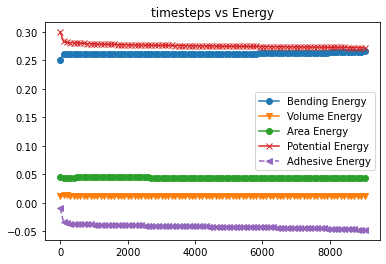

In [12]:
time=np.linspace(0,i,len(EnergyBending))
# plt.plot(time,totalEnergy,'o-', color='red', label='total Energy')
plt.plot(time,EnergyBending,'o-', label='Bending Energy')
plt.plot(time,EnergyVolume,'v-', label='Volume Energy')
plt.plot(time,EnergyArea,'o-', label='Area Energy')
plt.plot(time,PotentialEnergy,'x-',label='Potential Energy')
plt.plot(time,EnergyAdhesive,'<--',label='Adhesive Energy')
# plt.plot(time,KineticEnergy,'v-', label='Kinetic Energy',color='k')
#plt.axis([0, 800, 0, 2])
plt.legend(loc='right')
plt.title('timesteps vs Energy')
plt.show()

In [13]:
# igl.write_triangle_mesh(os.path.join(root_folder,'08_15_2022/',"u=4,rho=1.off"), v, f)
# np.savetxt(os.path.join('08_15_2022/',"PE_u=4_rho=1.txt"), (PotentialEnergy))
# np.savetxt(os.path.join('08_15_2022/',"BE_u=4_rho=1.txt"), (EnergyBending))

In [14]:
mp.jupyter()
p=mp.plot(v,f,shading={"wireframe":True, "wire_color": "black", #Wireframerendering
                       "width": 300, "height": 300},return_plot=True)
# p.save("u=2,rho=4.html")
#p.add_lines(v,v+1*FB, shading={"line_color": "red"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0308010…

In [15]:
Volume_Final= cal_volumetot(v,f)
print(Volume_Final)
Volume_Final/Volume_new

3.9178758790491606


0.9997054260920836

In [16]:
distance=np.zeros(len(v))
dc=np.zeros(len(v))
for i in range(len(v)):
    distance[i]=np.sqrt((((v[i][0])-x)**2)+(((v[i][1])-y)**2)+(((v[i][2])-z)**2))
    dc[i]=distance[i]-rp
    
type(dc)
print('Min distance:',dc.min())
print('Max distance:',dc.max())
# def histogram_distances_default(dc):
#     hist, bin_edges = np.histogram(dc)
#     return hist, bin_edges
# def plot_histogram(hist,bin_edges):
#     #for N bins, there are N+1 bin edges. The centers can be found by averaging the positions of
#     # bin edge0 and 1, 1 and 2, ..., N-1 and N
#     bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.0
#     plt.plot(bin_centers,hist,marker='')
#     plt.ylabel('Number of Vertices(r)')
#     plt.xlabel('radial distance')
#     plt.title('Radial Distribution Function')
# dist_hist_1, bin_edges_1 = histogram_distances_default(dc)
# plot_histogram(dist_hist_1,bin_edges_1)


# plt.hist(dc,bins=100)
# plt.show()

Min distance: -0.0022685642097486913
Max distance: 1.9660932108311058


# Mesh in (v, f)
A=igl.write_triangle_mesh(os.path.join(root_folder,'rho=0.05/',"u=4,rho=1.off"), v, f) 

(-1.0, 1.0)

<Figure size 432x288 with 0 Axes>

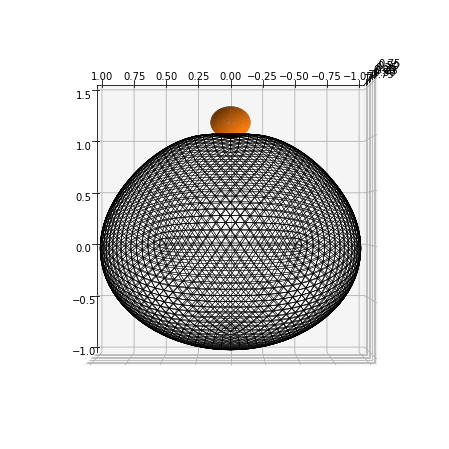

In [17]:
fig = plt.figure()

fig = plt.figure(figsize =(14, 8))
ax = plt.axes(projection ='3d')
surf=ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, edgecolor=[[0,0,0]], linewidth=0.4, alpha=0.0, shade=False)
#ax.plot_surface(x, y, z)
u, v1 = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
x1 = (rp*(np.cos(u) * np.sin(v1)))+x
y1 = (rp*(np.sin(u) * np.sin(v1)))
z1 = (rp*(np.cos(v1)))
surf=ax.plot_surface(x1, y1, z1)
ax.view_init(90,180)
ax = plt.gca()
ax.set_xlim([-1, 1.5])
ax.set_ylim([-1, 1])